In [2]:
# GPU
!nvidia-smi

# CPU info
!cat /proc/cpuinfo | grep 'model name' | uniq

# RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print(f"Total RAM: {ram_gb:.2f} GB")

# Disk info
!df -h /

Mon Aug 11 02:58:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# import zipfile
# import os

# # Giả sử tên tệp zip là your_file.zip
# with zipfile.ZipFile('Dataset - Copy.zip', 'r') as zip_ref:
#     zip_ref.extractall('sample_data')  # Chọn thư mục đích

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# # Giải nén file zip
# !unzip -q "/content/drive/MyDrive/content/Dataset.zip" -d "/content/drive/MyDrive/"

# Import libraries, load and transform data

In [7]:
# Cài đặt các gói Python cần thiết bằng pip

# Sử dụng lệnh 'pip' để cài đặt các gói
# '-q' có nghĩa là 'yên lặng', nghĩa là nó sẽ chặn hầu hết các đầu ra, làm cho quá trình cài đặt bớt rườm rà hơn
# Cài đặt các gói
# - 'evaluate': Gói này có thể được sử dụng cho mục đích đánh giá
# - 'transformers': Gói này thường được sử dụng cho các tác vụ xử lý ngôn ngữ tự nhiên, chẳng hạn như làm việc với các mô hình ngôn ngữ được đào tạo trước như BERT hoặc GPT
# - 'datasets': Gói này cung cấp quyền truy cập dễ dàng vào nhiều tập dữ liệu thường được sử dụng trong các tác vụ học máy và xử lý ngôn ngữ tự nhiên
# - 'mlflow': MLflow là một nền tảng nguồn mở để quản lý vòng đời học máy từ đầu đến cuối, bao gồm theo dõi các thí nghiệm, đóng gói mã thành các lần chạy có thể tái tạo và chia sẻ và triển khai các mô hình

!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [8]:
# Nhập các thư viện và mô-đun cần thiết
import warnings  # Nhập mô-đun 'cảnh báo' để xử lý cảnh báo
warnings.filterwarnings("ignore")  # Bỏ qua các cảnh báo trong khi thực hiện

import gc # Nhập mô-đun 'gc' để thu gom rác
import numpy as np
import pandas as pd
import itertools  # Nhập 'itertools' cho trình lặp và vòng lặp
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

# Nhập vào module và các lớp tùy chỉnh
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [9]:
# Nhập mô-đun cần thiết từ Thư viện hình ảnh Python (PIL).
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
# use https://huggingface.co/docs/datasets/image_load for reference


image_dict = {}


from pathlib import Path
from tqdm import tqdm
import os

# Khởi tạo danh sách trống để lưu trữ tên tệp và nhãn
file_names = []
labels = []

# Lặp lại tất cả các tệp hình ảnh trong thư mục được chỉ định
for file in sorted((Path('/content/drive/MyDrive/content/Dataset_1').glob('*/*/*.*'))):
    label = str(file).split('/')[-2]  # Trích xuất nhãn từ đường dẫn tệp
    labels.append(label)  # Thêm nhãn vào danh sách
    file_names.append(str(file))  # Thêm đường dẫn tệp vào danh sách

# In tổng số tên tệp và nhãn
print(len(file_names), len(labels))

# Tạo một dataframe từ các tên tệp và nhãn đã thu thập
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

13596 13596
(13596, 2)


In [12]:
# In ra các giá trị đầu của dataframe
df.head()

,image,label
0,/content/drive/MyDrive/content/Dataset_1/Test/...,Fake
1,/content/drive/MyDrive/content/Dataset_1/Test/...,Fake
2,/content/drive/MyDrive/content/Dataset_1/Test/...,Fake
3,/content/drive/MyDrive/content/Dataset_1/Test/...,Fake
4,/content/drive/MyDrive/content/Dataset_1/Test/...,Fake


In [13]:
# In ra các label
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [14]:
# 'y' chứa biến mục tiêu (nhãn) muốn dự đoán
y = df[['label']]

# Xóa cột 'nhãn' khỏi DataFrame 'df' để tách các tính năng khỏi biến mục tiêu
df = df.drop(['label'], axis=1)

# Tạo một đối tượng RandomOverSampler với (random_state=83)
ros = RandomOverSampler(random_state=83)

# 'df' chứa dữ liệu đặc điểm và 'y_resampled' sẽ chứa biến mục tiêu được lấy mẫu lại
df, y_resampled = ros.fit_resample(df, y)

# Xóa biến 'y' ban đầu để tiết kiệm bộ nhớ vì nó không còn cần thiết nữa
del y

# Thêm biến mục tiêu được lấy mẫu lại 'y_resampled' làm cột 'nhãn' mới trong DataFrame 'df'
df['label'] = y_resampled

# Xóa biến 'y_resampled' để tiết kiệm bộ nhớ vì nó không còn cần thiết nữa
del y_resampled

# Thực hiện thu gom rác để giải phóng bộ nhớ được sử dụng bởi các biến bị loại bỏ
gc.collect()

print(df.shape)

(13606, 2)


In [15]:
# Tạo một tập dữ liệu từ Pandas DataFrame.
dataset = Dataset.from_pandas(df).cast_column("image", Image())

In [16]:
# Display the first image in the dataset
# dataset[0]["image"]

In [17]:
# Hiển thị 5 phần tử đầu tiên
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [18]:
# Tạo danh sách các nhãn duy nhất bằng cách chuyển đổi 'label' thành một tập hợp rồi chuyển lại thành danh sách
labels_list = ['Real', 'Fake'] # list(set(labels))

# Khởi tạo các từ điển trống để ánh xạ nhãn thành ID và ngược lại
label2id, id2label = dict(), dict()

# Lặp lại các nhãn duy nhất và gán cho mỗi nhãn một ID, và ngược lại
for i, label in enumerate(labels_list):
    label2id[label] = i  # Ánh xạ nhãn tới ID tương ứng của nó
    id2label[i] = label  # Ánh xạ ID tới nhãn tương ứng của nó

# In các từ điển kết quả để tham khảo
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [19]:
# Tạo nhãn lớp để khớp nhãn với ID
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Ánh xạ nhãn với ID
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Ép kiểu cột nhãn thành đối tượng ClassLabel
dataset = dataset.cast_column('label', ClassLabels)

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra bằng tỷ lệ chia 60-40.
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Trích xuất dữ liệu đào tạo từ tập dữ liệu phân tách.
train_data = dataset['train']

# Trích xuất dữ liệu thử nghiệm từ tập dữ liệu phân tách.
test_data = dataset['test']

Map:   0%|          | 0/13606 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/13606 [00:00<?, ? examples/s]

In [20]:
# Xác định chuỗi mô hình ViT được đào tạo trước
model_str = "dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'
# model_str = "google/vit-base-patch16-224-in21k"

# Tạo bộ xử lý cho đầu vào mô hình ViT từ mô hình được đào tạo trước
processor = ViTImageProcessor.from_pretrained(model_str)

# Lấy giá trị trung bình và độ lệch chuẩn của hình ảnh được sử dụng để chuẩn hóa
image_mean, image_std = processor.image_mean, processor.image_std

# Lấy kích thước (chiều cao) của hình ảnh đầu vào của mô hình ViT
size = processor.size["height"]
print("Size: ", size)

# Xác định phép biến đổi chuẩn hóa cho hình ảnh đầu vào
normalize = Normalize(mean=image_mean, std=image_std)

# Xác định một tập hợp các phép biến đổi cho training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Thay đổi kích thước hình ảnh theo kích thước đầu vào của mô hình ViT
        RandomRotation(90),               # Áp dụng phép quay ngẫu nhiên
        RandomAdjustSharpness(2),         # Điều chỉnh độ sắc nét ngẫu nhiên
        ToTensor(),                       # Chuyển đổi hình ảnh thành tensors
        normalize                         # Chuẩn hóa hình ảnh bằng cách sử dụng giá trị trung bình và giá trị chuẩn
    ]
)

# Xác định một tập hợp các phép biến đổi cho validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Thay đổi kích thước hình ảnh theo kích thước đầu vào của mô hình ViT
        ToTensor(),                       # Chuyển đổi hình ảnh sang tensors
        normalize                         # Chuẩn hóa hình ảnh bằng cách sử dụng giá trị trung bình và giá trị chuẩn
    ]
)

# Xác định một hàm để áp dụng các phép biến đổi đào tạo cho một loạt ví dụ
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Xác định một hàm để áp dụng các phép biến đổi xác thực cho một loạt ví dụ
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Size:  224


In [21]:
# Thiết lập các chuyển đổi cho training data
train_data.set_transform(train_transforms)

# Thiết lập chuyển đổi cho test/validation data
test_data.set_transform(val_transforms)

In [22]:
# Xác định hàm đối chiếu chuẩn bị dữ liệu theo batched để đào tạo mô hình.
def collate_fn(examples):
    # Xếp chồng các giá trị pixel từ các ví dụ riêng lẻ thành một tensor duy nhất.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Chuyển đổi chuỗi nhãn trong ví dụ thành ID số tương ứng bằng cách sử dụng từ điển label2id.
    labels = torch.tensor([example['label'] for example in examples])

    # Trả về một từ điển chứa các nhãn và giá trị pixel được xử lý theo batched
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [23]:
# Tạo mô hình ViTForImageClassification từ điểm kiểm tra được đào tạo trước với số lượng nhãn đầu ra được chỉ định.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Cấu hình ánh xạ nhãn lớp tới các chỉ mục tương ứng để tham khảo sau.
model.config.id2label = id2label
model.config.label2id = label2id

# Tính toán và in ra số lượng tham số có thể đào tạo được tính bằng triệu cho mô hình.
print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

85.800194


In [24]:
# Tải số accuracy metric từ mô-đun 'evaluate'
accuracy = evaluate.load("accuracy")

# Xác định hàm 'compute_metrics' để tính toán số liệu đánh giá
def compute_metrics(eval_pred):
    # Trích xuất dự đoán mô hình từ đối tượng dự đoán đánh giá
    predictions = eval_pred.predictions

    # Trích xuất nhãn thực từ đối tượng dự đoán đánh giá
    label_ids = eval_pred.label_ids

    # Chuyển đổi dự đoán mô hình thành nhãn lớp bằng cách chọn lớp có xác suất cao nhất (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Tính accuracu score bằng cách so sánh nhãn dự đoán với nhãn thực
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Trả về độ chính xác được tính toán dưới dạng từ điển với khóa "accuracy"
    return {
        "accuracy": acc_score
    }


In [25]:
# Xác định tên của số liệu đánh giá sẽ được sử dụng trong quá trình đào tạo và đánh giá.
metric_name = "accuracy"

# Xác định tên của mô hình, tên này sẽ được sử dụng để tạo thư mục lưu các điểm kiểm tra và đầu ra của mô hình.
model_name = "Manh_deepfake_vs_real_image_detection_Manh"

# Xác định số lượng epochs đào tạo cho mô hình
num_train_epochs = 2

# Tạo một phiên bản TrainingArguments để cấu hình cài đặt đào tạo.
args = TrainingArguments(
    # Chỉ định thư mục nơi các điểm kiểm tra và đầu ra của mô hình sẽ được lưu.
    output_dir=model_name,

    # Chỉ định thư mục nơi training logs sẽ được lưu trữ.
    logging_dir='./logs',

    # Xác định chiến lược đánh giá được thực hiện vào cuối mỗi epoch.
    # evaluation_strategy="epoch",
    eval_strategy="epoch",

    # Thiết lập learning rate cho trình tối ưu hóa.
    learning_rate=1e-6,

    # Xác định batch size để đào tạo trên mỗi thiết bị.
    per_device_train_batch_size=32,

    # Xác định batch size để đánh giá trên mỗi thiết bị.
    per_device_eval_batch_size=8,

    # Chỉ định tổng số training epochs.
    num_train_epochs=num_train_epochs,

    # Áp dụng weight decay để ngăn ngừa tình trạng overfitting.
    weight_decay=0.02,

    # Thiết lập số bước warmup cho bộ lập lịch learning rate.
    warmup_steps=50,

    # Vô hiệu hóa việc xóa các cột không sử dụng khỏi tập dữ liệu.
    remove_unused_columns=False,

    # Xác định chiến lược để lưu các điểm kiểm tra mô hình (mỗi epoch trong mỗi trường hợp).
    save_strategy='epoch',

    # Tải mô hình tốt nhất vào cuối quá trình đào tạo.
    load_best_model_at_end=True,

    # Giới hạn tổng số điểm kiểm tra đã lưu để tiết kiệm dung lượng.
    save_total_limit=1,

    # Chỉ rõ rằng tiến trình đào tạo không nên được báo cáo.
    report_to="none"
)

In [26]:
# Tạo một phiên bản Trainer để tinh chỉnh mô hình ngôn ngữ.

# - `model`: Mô hình ngôn ngữ pre-trained sẽ được tinh chỉnh.
# - `args`: Thiết lập cấu hình và siêu tham số để đào tạo.
# - `train_dataset`: Bộ dữ liệu được sử dụng để đào tạo mô hình.
# - `eval_dataset`: Bộ dữ liệu được sử dụng để đánh giá mô hình trong quá trình đào tạo.
# - `data_collator`: Một hàm xác định cách thức tập hợp và xử lý các batchs dữ liệu.
# - `compute_metrics`: Một chức năng để tính toán metrics đánh giá tùy chỉnh.
# - `tokenizer`: Công cụ phân tích được sử dụng để xử lý dữ liệu văn bản.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [27]:
# Đánh giá hiệu suất của mô hình đào tạo trước trên test dataset.
# Hàm tính toán nhiều số liệu khác nhau như accuracy, loss, etc.,

# trainer.evaluate()
import time

# Bắt đầu đo thời gian
start_time = time.time()

# Thực thi lệnh evaluate
trainer.evaluate()

# Kết thúc đo thời gian
end_time = time.time()

# Tính toán thời gian chạy
execution_time = end_time - start_time

# In ra thời gian chạy
print(f"Thời gian chạy: {execution_time:.2f} giây")

Thời gian chạy: 1583.85 giây


In [28]:
# Bắt đầu đào tạo mô hình bằng cách sử dụng đối tượng đào tạo.
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.027566,0.004900,0.991365
2,0.041800,0.026894,0.004900,0.991549


TrainOutput(global_step=512, training_loss=0.04156364465598017, metrics={'train_runtime': 2857.9671, 'train_samples_per_second': 5.712, 'train_steps_per_second': 0.179, 'total_flos': 1.265134222447829e+18, 'train_loss': 0.04156364465598017, 'epoch': 2.0})

In [29]:
# Đánh giá hiệu suất của mô hình sau khi đào tạo trên validation or test dataset.
# Hàm tính toán nhiều số liệu đánh giá khác nhau như accuracy, loss, etc.
# cung cấp thông tin chi tiết về hiệu suất của mô hình.

trainer.evaluate()

{'eval_loss': 0.026893941685557365,
 'eval_model_preparation_time': 0.0049,
 'eval_accuracy': 0.9915487782472902,
 'eval_runtime': 78.1879,
 'eval_samples_per_second': 69.614,
 'eval_steps_per_second': 8.71,
 'epoch': 2.0}

In [30]:
# Sử dụng 'trainer' đã được đào tạo để đưa ra dự đoán về 'test_data'.
outputs = trainer.predict(test_data)


# In các số liệu thu được từ kết quả dự đoán.
print(outputs.metrics)

{'test_loss': 0.026893941685557365, 'test_model_preparation_time': 0.0049, 'test_accuracy': 0.9915487782472902, 'test_runtime': 78.0908, 'test_samples_per_second': 69.701, 'test_steps_per_second': 8.721}


Accuracy: 0.9915
F1 Score: 0.9915


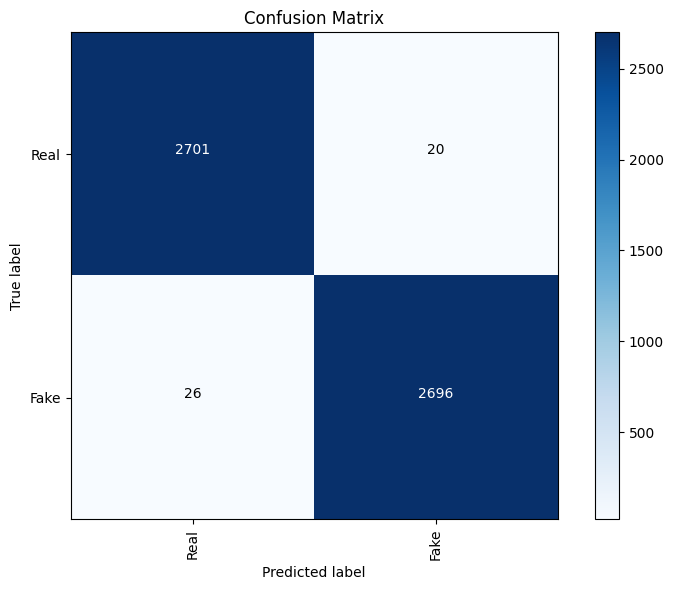


Classification report:

              precision    recall  f1-score   support

        Real     0.9905    0.9926    0.9916      2721
        Fake     0.9926    0.9904    0.9915      2722

    accuracy                         0.9915      5443
   macro avg     0.9916    0.9915    0.9915      5443
weighted avg     0.9916    0.9915    0.9915      5443



In [31]:
# Trích xuất các nhãn thực từ đầu ra của mô hình
y_true = outputs.label_ids

# Dự đoán các nhãn bằng cách chọn lớp có xác suất cao nhất
y_pred = outputs.predictions.argmax(1)

# Xác định một hàm để vẽ ma trận nhầm lẫn
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Ma trận nhầm lẫn được trả về bởi sklearn.metrics.confusion_matrix.
        classes (list): Danh sách tên lớp ['Class 0', 'Class 1'].
        title (str): Tiêu đề cho biểu đồ.
        cmap (matplotlib colormap): Bản đồ màu cho biểu đồ.
    """
    # Tạo một hình có kích thước xác định
    plt.figure(figsize=figsize)

    # Hiển thị ma trận nhầm lẫn dưới dạng hình ảnh có bản đồ màu
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Xác định các dấu tích và nhãn cho các lớp trên trục
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Thêm chú thích văn bản vào biểu đồ để chỉ ra các giá trị trong các ô
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label các trục
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Đảm bảo bố cục biểu đồ chặt chẽ
    plt.tight_layout()
    # Hiển thị biểu đồ
    plt.show()

# Tính toán accuracy và F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Hiển thị accuracy và F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Nhận ma trận nhầm lẫn nếu có một số lượng nhỏ labels
if len(labels_list) <= 150:
    # Tính toán ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)

    # Vẽ ma trận nhầm lẫn bằng hàm đã xác định
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Cuối cùng, hiển thị báo cáo phân loại
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [32]:
# Lưu mô hình đã được đào tạo
# Nó sẽ tuần tự hóa mô hình và các trọng số liên quan của nó
# có thể tải lại và sử dụng mô hình
# trong tương lai mà không cần phải đào tạo lại.
trainer.save_model()

In [33]:
# Nhập hàm 'pipeline' từ thư viện 'transformers'.
from transformers import pipeline

# Tạo pipeline cho các tác vụ phân loại hình ảnh.
# Chỉ định 'model_name' và 'device' để sử dụng cho suy luận.
# - 'model_name': Tên của mô hình pre-trained sẽ được sử dụng để phân loại hình ảnh.
# - 'device': Chỉ định thiết bị sử dụng để chạy mô hình (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [34]:
# # # Accessing an image from the 'test_data' dataset using index 1.
# # image = test_data[1]["image"]

# from PIL import Image

# # Load ảnh từ file
# image_path = "/content/gengar_4.jpeg"
# image = Image.open(image_path)

# # Hiển thị biến 'image'
# image

In [35]:
# # Áp dụng hàm 'pipe' để xử lý biến 'image'.
# pipe(image)

In [36]:
# id2label[test_data[1]["label"]]